# Mathematical methods for Bioengineers - Coursework 1
Victoire de Saléon-Terras - November 2022

This coursework is based on the work of Mary Ann Go, Jake Rogers, Giuseppe P. Gava, Catherine Davey, Seigfred Prado, Yu Liu and Simon R. Schultz. The paper (2020) is the first demonstration of place cells in head-fixed mice navigating on an air-lifted real-world platform, validating its use for the study of brain circuits involved in memory and affected by neurodegenerative disorders. The dataset used for this study is from their two photon calcium fluorescence imaging experiment.

Here are the different libraries and functions used for the study:

In [1]:
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
from scipy.signal import correlate
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

## 1. Introduction
### 1.1. Load datasets
We load the calcium imaging dataset provided in the directory dataset3_m62 using the skeleton code ‘skel_coursework1.py’.

In [2]:
datadir = 'data/dataset3_m62/'                       # file direction
trackdata = io.loadmat(datadir+'downTrackdata.mat')  # loading dataset
phi = trackdata['phi']                               # angle position
x = trackdata['x']                                   # x position (mm)
y = trackdata['y']                                   # y position (mm)
r = trackdata['r']                                   # radial position
speed = trackdata['speed']                           # speed (mm/s)
t = trackdata['time']                                # time (s)
spikedata = io.loadmat(datadir+'spikes.mat')         # loading dataset
spikes = spikedata['spikes']
params = spikedata['params']
fluodata = io.loadmat(datadir+'fissa_output.mat')    # loading dataset
dfonf = fluodata['ddf_f']                            # fluorescence time series

### 1.2. Some useful parameters

In [3]:
cell_ID = 1                                          # indice of the second cell
N = len(t)
print('number of samples (times): N='+str(N))
n = dfonf.shape[0]
print('number of features (cells): n='+str(n))
f=params['fr'][0][0][0][0]
print('frequency: f='+str(f)+'Hz')
dt = 1/f
print('time intervall: dt='+str(dt)+' s')

number of samples (times): N=44520
number of features (cells): n=138
frequency: f=30.9Hz
time intervall: dt=0.03236245954692557 s


### 1.2. About the note A
The data were collected by concatenating multiple 4-minute video files collected 
from the microscope. Each of these is separated by an unknown gap in time – for this reason, 
the time variable ‘t’ does not linearly increase but restarts each for each video. This means 
that we can expect the spatial position of the mouse to jump at each of these discontinuities. 
For the purpose of the current analysis, this does not matter, but we create a 
new time variable ('time') which just counts time linearly from the start, and we take note of the times 
at which these jumps in position occur ('ind')

indices of the jumps : [ 7419 14839 22259 29679 37099 44520]
total duration of the recording: 1440.6745242718448 s = approx. 24 min


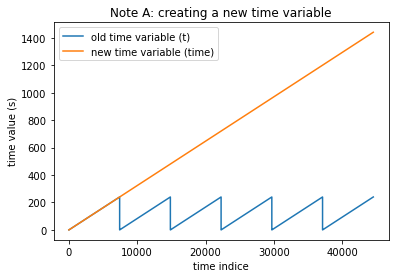

In [4]:
ind = np.where(t[:-1]-t[1:]>100)[0]
ind = np.append(ind,N)
print('indices of the jumps :',ind)

time = np.copy(t)                                    # creating the new time variable
t0 = 0
for i in range(len(ind)-1):
    t0 = t0+t[ind[i]]
    time[ind[i]] = t0
    for j in range(ind[i]+1,ind[i+1]):
        time[j]=t[j]+time[ind[i]]

print('total duration of the recording: '+str(time[-1][0])+' s = approx. '+str(int(time[-1][0]/60))+' min')

fig,ax = plt.subplots(1)                             # plotting the two time variables
ax.plot(t)
ax.plot(time)
ax.set_xlabel('time indice')
ax.set_ylabel('time value (s)')
plt.title('Note A: creating a new time variable')
plt.legend(['old time variable (t)','new time variable (time)'])
plt.show()

Now we have a new variable which counts time linearly from the start. It has N values with an time intervall of dt.
### 1.3. Questions 1a and 1b
We plot the fluorescence time series as a function of time of the second cell and, as a subplot with the same time axis, we plot the angular position of the mouse. As the whole recording lasts 24 minutes, we will also plot the same graphs for a small portion of the signal. All the variables corresponding to the small portion will have the same name as those corresponding to the whole signal, but with also a $\_ p$ indice.

portion between: t1=300.0046375404531s and time 2=420.71661165048545 s
duration of the small portion of the signal: 120.71197411003237 s
new number of samples: N_p=3730


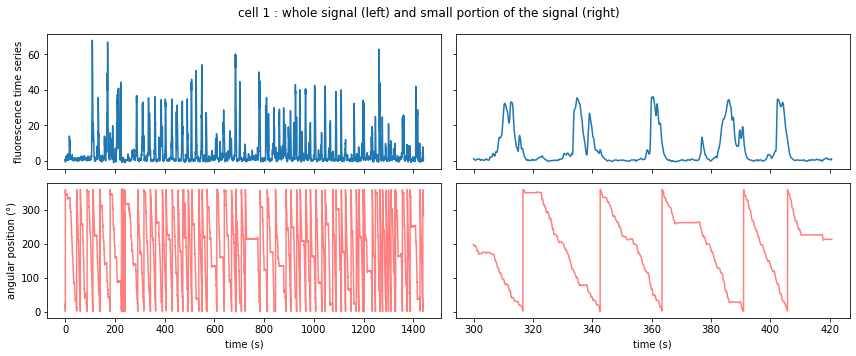

In [5]:
i1 = 9270            # indices of the small portion of the signal
i2 = 13000
print('portion between: t1='+str(time[i1][0])+'s and time 2='+str(time[i2][0])+' s')
print('duration of the small portion of the signal: '+str(time[i2][0]-time[i1][0])+' s')

dfonf_p = dfonf[:,i1:i2]
N_p=dfonf_p.shape[1]            # number of samples (time)
print('new number of samples: N_p='+str(N_p))
phi_p = phi[i1:i2]
time_p = time[i1:i2]

fig,((ax1,ax3),(ax2,ax4)) = plt.subplots(2,2,sharex='col',sharey='row',figsize=(12,5))
title='cell '+str(cell_ID)+' : whole signal (left) and small portion of the signal (right)'
fig.suptitle(title)

ax1.plot(time,dfonf[cell_ID])
ax1.set_ylabel('fluorescence time series')
ax2.plot(time,phi,'r',alpha=0.5)
ax2.set_ylabel('angular position (°)')
ax2.set_xlabel('time (s)')

ax3.plot(time_p,dfonf_p[cell_ID])
ax4.plot(time_p,phi_p,'r',alpha=0.5)
ax4.set_xlabel('time (s)')

plt.tight_layout()
plt.show()

The fluorescence time series shows many peaks corresponding to the cell activity. The angular position varies from 359° to 0° and jump back to 359° when the loop is finished. By zooming in the small portion of the signal we can observe that the cell seems to have a response each time the angular value is approximatly between 0 and 100°. The mouse has made 5 turns in the circle during the selected portion.
### 1.4. Question 1c
Now, we plot the trajectory of the mouse in space (cartesian coordinates) throughout the whole duration of the recording (left) and during the selected small portion (right).

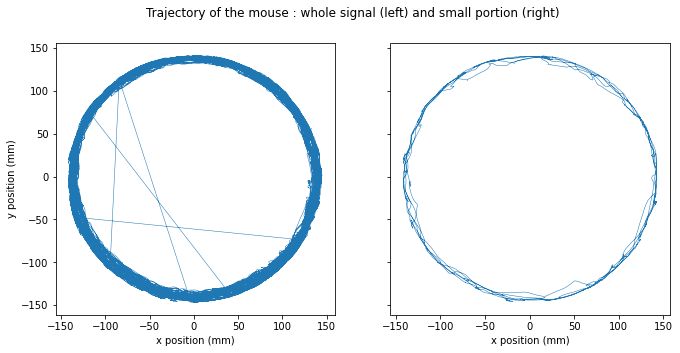

In [6]:
fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(11,5))
fig.suptitle('Trajectory of the mouse : whole signal (left) and small portion (right)')
ax1.plot(x,y,linewidth=0.5)
ax1.set_xlabel('x position (mm)')
ax1.set_ylabel('y position (mm)')
ax2.plot(x[i1:i2],y[i1:i2],linewidth=0.5)
ax2.set_xlabel('x position (mm)')
plt.tight_layout
plt.show()

The trajectory of the mouse is circular, as shown in in these figures. The diameter is approximatly 30 cm, as confirmed in the paper. The lines crossing the circles corresponds to the "jumps" of the position of the mouse due to the change of video.
### 1.5. Question d
We calculate the average response of this cell at each angular position phi, using the raw fluorescence signal. All the angular positions are rounded to the nearest integer. For each of the 360 values, we calculate the mean of the corresponding fluorescence value. Then, we plot the calculated average in the same graph as the raw fluorescence data.

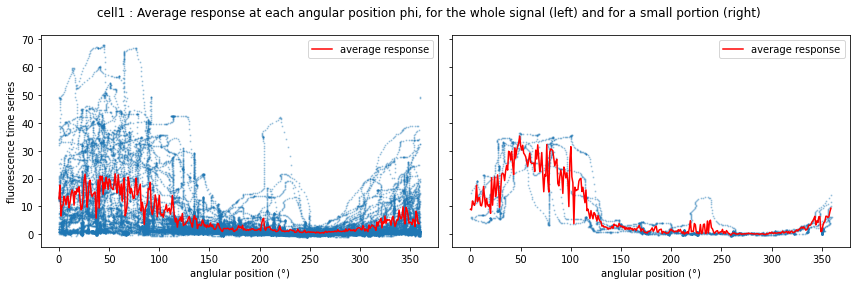

In [7]:
PHI = np.unique(np.floor(phi))                                        # [0,1,...,359] here (°)
m1,m2 = np.zeros((np.shape(PHI)[0])),np.zeros((np.shape(PHI)[0]))     # arrays of means of response at each angular position
for i in range(np.shape(PHI)[0]):
    m1[i]=np.mean(dfonf[cell_ID][np.floor(phi[:,0])==PHI[i]])
    m2[i]=np.mean(dfonf_p[cell_ID][np.floor(phi_p[:,0])==PHI[i]])

fig,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(12,4))
plt.suptitle('cell'+str(cell_ID)+' : Average response at each angular position phi, for the whole signal (left) and for a small portion (right)')

ax1.scatter(phi,dfonf[cell_ID],alpha=0.3,s=1)
ax1.plot(PHI,m1,'r',label='average response')
ax1.set_xlabel('anglular position (°)')
ax1.set_ylabel('fluorescence time series')
ax1.legend()

ax2.scatter(phi_p,dfonf_p[cell_ID],alpha=0.3,s=1)
ax2.plot(PHI,m2,'r',label='average response')
ax2.set_xlabel('anglular position (°)')
ax2.legend()

plt.tight_layout()
plt.show()

This cell has a more important response for angular positions around 50°. Therefore, this cell is tuned for spatial location.
## 2. Delay embedding (Question 2)
Plotting the delay embedding may be very informative to represent the dynamic of the system. The dimension of the time embedding is $m=2$. Therefore, the aim of this section is to plot the fluorescence time series at a time $t$ against the same fluorescence time serie at a time $t-\tau$. It allows to visualize the behavour of the system after a time interval of $\tau$.
### 2.1. Fluorescence time series autocorrelation
To help us choose the appropriate time lag $\tau$, we first plot the fluorescence time series autocorrelation.

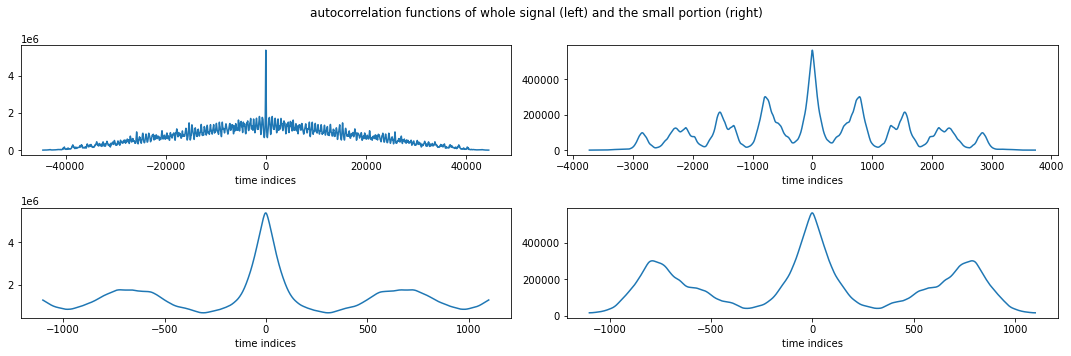

In [8]:
ac = correlate(dfonf[cell_ID],dfonf[cell_ID])
tc = np.arange(0-N,0+N-1,1)                            # time indices
ac_p = correlate(dfonf_p[cell_ID],dfonf_p[cell_ID])
tc_p = np.arange(0-N_p,0+N_p-1,1)                        # time indices

fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(15,5))
plt.suptitle('autocorrelation functions of whole signal (left) and the small portion (right)')
ax1.plot(tc,ac)
ax1.set_xlabel('time indices')

ax2.plot(tc_p,ac_p)
ax2.set_xlabel('time indices')

NT = 1100                                               # size of the zoom in the autocorrelation function (in time indices)
ax3.plot(np.arange(0-NT,0+NT,1),ac[int(N-NT):int(N+NT)])
ax3.set_xlabel('time indices')
ax4.plot(np.arange(0-NT,0+NT,1),ac_p[int(N_p-NT):int(N_p+NT)])
ax4.set_xlabel('time indices')
plt.tight_layout()
plt.show()

We note that :
- the maximum is obtained for a time lag of zero, which is logic because the values correlate the most with themselves
- the autocorrelation periodically reaches maximums and minimums, showing that the fluorescence time series periodically autocorrelates a lot
- for the small portion of the signal: the first minimums are reached at the time indices $-322$ and $+322$ which means that with a time lag of $\tau=322 \times dt =10.4s$ the data is highly uncorrelated
- on the contrary, the first maximums exept for the central peak are reached at the time indices $-789$ and $+789$ which means that after a time lag of $\tau= 789 \times dt =25.5s$ the fluorescence data is pretty similar
### 2.2. Plotting the delay embedding
To understand the behavior of the system we are going to plot the delay embedding with 4 different time lags. On the left column of plots the graphs corresponds to the whole signal and on the right column, the graphs corresponds to the smal portion.

list of time lags indices: [  1  10 322 789]
list of time lags: [ 0.03  0.32 10.42 25.53]


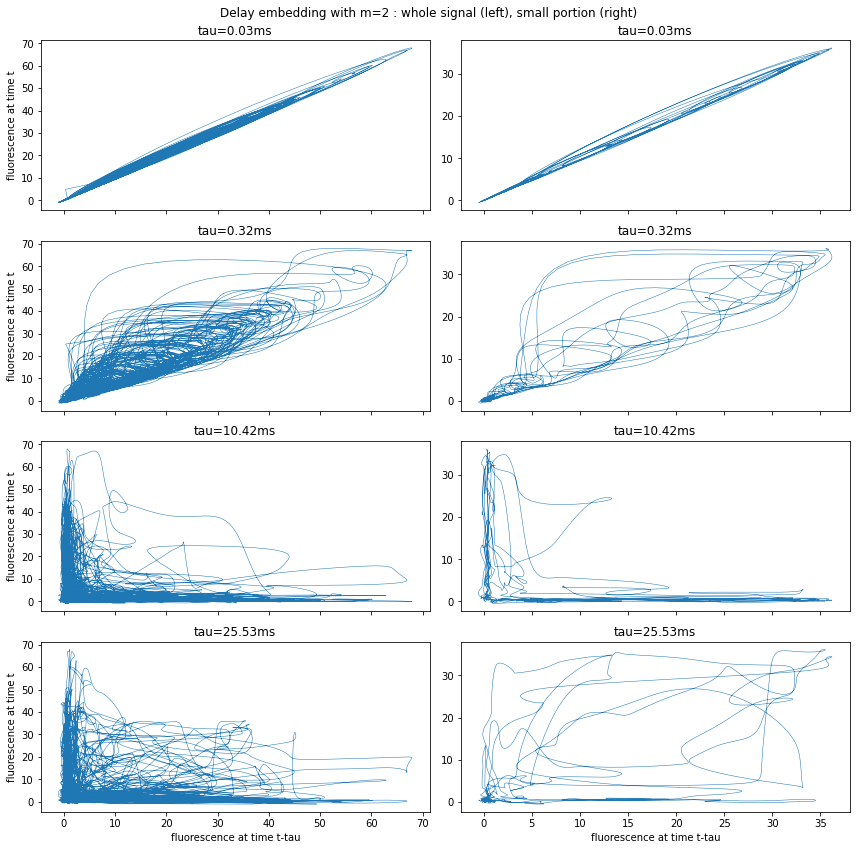

In [9]:
fig,ax = plt.subplots(4,2,sharex='col',figsize=(12,12))
tau_ind=np.asarray([1,10,322,789])                        # array of time lag indices
print('list of time lags indices:',tau_ind)
tau=np.floor(tau_ind*dt*100)/100                         # array of rounded time lag
print('list of time lags:',tau)

plt.suptitle('Delay embedding with m=2 : whole signal (left), small portion (right)')
for i in [0,1,2,3]:
    dfonf_x = dfonf[cell_ID][:-tau_ind[i]]
    dfonf_y = dfonf[cell_ID][tau_ind[i]:]
    ax[i,0].plot(dfonf_x,dfonf_y,linewidth=0.5)
    ax[i,1].plot(dfonf_p[cell_ID][:-tau_ind[i]],dfonf_p[cell_ID][tau_ind[i]:],linewidth=0.5)
    ax[i,0].title.set_text('tau='+str(tau[i])+'ms')
    ax[i,1].title.set_text('tau='+str(tau[i])+'ms')
    ax[i,0].set_ylabel('fluorescence at time t')

ax[3,0].set_xlabel('fluorescence at time t-tau')
ax[3,1].set_xlabel('fluorescence at time t-tau')
plt.tight_layout()
plt.show()

For small time lags ($\tau=0.03s$ or $\tau=0.32s$), the values are clustered around the diagonal since successive elements are strongly correlated. On the contrary, as mentioned in the section 2.1. for a time lag $\tau=10.41s$, the elements are strongly uncorrelated: if an element is located on a peak at time $t$, then at $t-\tau$ the corresponding element is at a minimum, that explains the behavior of the third line. Finally, for a time lag $tau=25.53s$, the elements are more correlated, which explains why they are closer to the diagonal.
## 3. Recurrence plot (Question 3)
Displaying recurrence plots is useful to show for each moments of time, the times at which the system returns to the same state. We are going to display a $N\times N$ matrix $R$ such as:
\begin{equation}
R(i,j)=0 \mbox{ if } |\mbox{dfonf}(i)-\mbox{dfonf}(j)|<eps \\
R(i,j)=1 \mbox{ otherwise }
\end{equation}
With eps an appropriate tolerance to see meaningful structure in the data
### 3.1. Downsampling the dataset
Since the whole dataset lasts 24 min whith a time interval of 0.03 seconds, there is too many samples to process for the computers. Two solutions will be explored: working with only a small portion of the dataset as we have previously done (variables with the $\_ p$ indices). We will also consider an undersampled version of the dataset by using average pooling (the sampled variables will have the $\_ s$ indices). For this study, the new time intervall will be 15 times larger, but it can easily be changed in the line that follows:

In [10]:
dt_s = dt*15                            # new time intervall
N_s = int(time[-1]/dt_s)                 # new number of samples (number of times)
print('dt='+str(dt)+' ; dt_p='+str(dt)+' ; dt_s = '+str(dt_s))
print('N='+str(N)+' ; N_p='+str(N_p)+' ; N_s = '+str(N_s))

dfonf_s = np.zeros((n,N_s))        # creating the downsampled dataset
for c in range(n):
    dfonf_cellc = np.zeros(N_s)
    for i in range(N_s):
        jmin,jmax=int(i*dt_s/dt),int((i+1)*dt_s/dt)
        s=0
        for j in range(jmin,jmax):
            s+=dfonf[c][j]
        dfonf_cellc[i]=s/(jmax-jmin)
    dfonf_s[c,:]=dfonf_cellc

time_s = np.zeros(N_s)                   # creating new time variable
phi_s = np.zeros(N_s)
for i in range(N_s):
    time_s[i]=i*dt_s
    phi_s[i]=phi[int(i*dt_s/dt)]

dt=0.03236245954692557 ; dt_p=0.03236245954692557 ; dt_s = 0.48543689320388356
N=44520 ; N_p=3730 ; N_s = 2967


### 3.2. Plotting the result
The value of eps should not be too large as too many states will be considered as the same, but it shouldn't be too small as no state will be considered as the same.

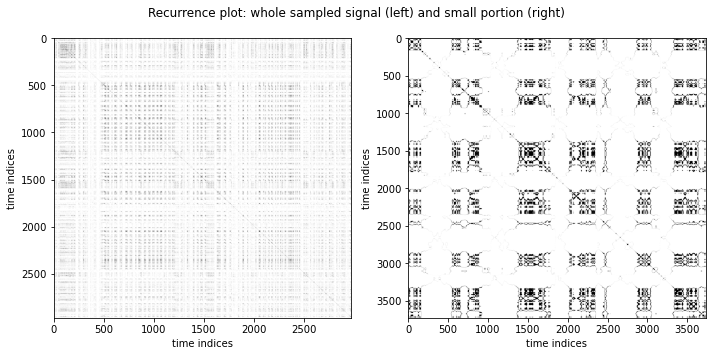

In [11]:
eps=0.2

dfonf_x = dfonf_s[cell_ID]
dfonf_y = dfonf_s[cell_ID]
X,Y = np.meshgrid(dfonf_x,dfonf_y)
diff_s=np.abs(abs(X-Y)<eps)

dfonf_x_p = dfonf_p[cell_ID]
dfonf_y_p = dfonf_p[cell_ID]
X,Y = np.meshgrid(dfonf_x_p,dfonf_y_p)
diff_p=np.abs(abs(X-Y)<eps)

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
plt.suptitle('Recurrence plot: whole sampled signal (left) and small portion (right)')
ax1.imshow(diff_s,cmap='Greys',aspect='auto')
ax1.set_xlabel('time indices')
ax1.set_ylabel('time indices')
ax2.imshow(diff_p,cmap='Greys',aspect='auto')
ax2.set_xlabel('time indices')
ax2.set_ylabel('time indices')
fig.tight_layout()
plt.show()

Both of the recurrence plots have a grid structure, showing that the system periodicaly reach the same state.
## 4. Dimension reduction of the whole dataset (Question 4)
Now we consider the whole population of neurons ($n=138$ cells). The aim of this section is to perform a dimension reduction, to simplify the high-dimensionality of the dataset, while retaining trends and patterns.
### 4.1. Activity
First, we can visualize the activity of the whole population of neurons by plotting an image with dimensions n x N (where n is the number of cells and N is the number of time points).

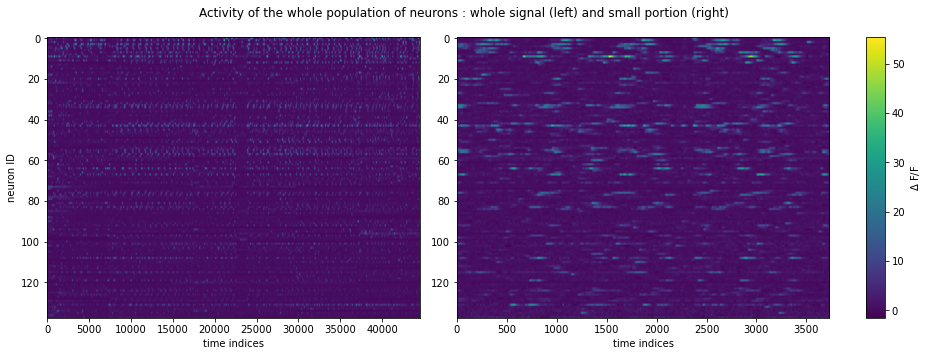

In [12]:
fig,(ax1,ax2,cax)=plt.subplots(1,3,figsize=(13,5),gridspec_kw={"width_ratios":[1,1, 0.05]})
plt.suptitle('Activity of the whole population of neurons : whole signal (left) and small portion (right)')

ax1.imshow(dfonf,aspect='auto')
ax1.set_ylabel('neuron ID')
ax1.set_xlabel('time indices')

im = ax2.imshow(dfonf_p,aspect='auto')
ax2.set_xlabel('time indices')

cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel(r'$\Delta$ F/F')
plt.tight_layout()
plt.show()

### 4.2. Similarity matrix
This time x time matrix ($N \times N$) aims to show how different the pattern of activity across all the cells are at two times t1 and t2.

In [13]:
cs_s = cosine_similarity(np.transpose(dfonf_s))
cs_p = cosine_similarity(np.transpose(dfonf_p))

The cosine similarity computes similarity as the normalized dot product of X and Y:
\begin{equation}
CS(X,Y)=\frac{<X,Y>}{||X||\times ||Y||}
\end{equation}

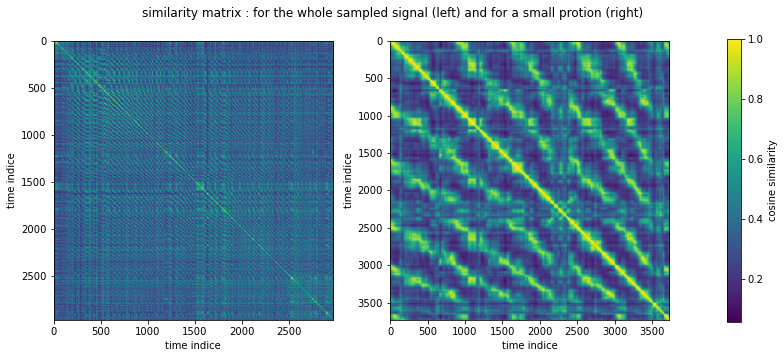

In [14]:
fig,(ax1,ax2,cax)=plt.subplots(1,3,figsize=(11,5),gridspec_kw={"width_ratios":[1,1, 0.05]})
plt.suptitle('similarity matrix : for the whole sampled signal (left) and for a small protion (right)')
ax1.imshow(cs_s)
ax1.set_xlabel('time indice')
ax1.set_ylabel('time indice')
im = ax2.imshow(cs_p)
ax2.set_xlabel('time indice')
ax2.set_ylabel('time indice')
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('cosine similarity')
fig.tight_layout()
plt.show()

As successive states are strongly correlated, the elements close to the diagonal have higher values. Then we can observe especially in the right graph that a same pattern repeats itself periodically over time.
### 4.4. Principal component analysis
Principal Component Analysis (PCA) is a statistical procedure to elucidate the covariance structure of a set of variables. It identifies the main directions in which the data vary. In this section, we first apply the principal component analysis fit function to the similarity matrix, to obtain the eigenvectors and eigenvalues of the covariance matrix of the dataset. Here we choose to calculate 10 components, which corresponds to the 10 components with the highest variance. Then we project the data into a lower-dimensional space that preserves most of the variance.

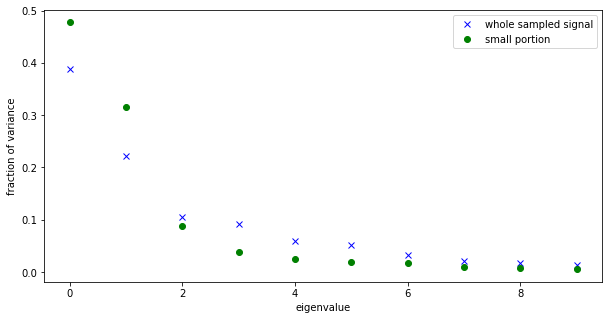

fraction of variance of the two firsts components :
whole undersampled signal:  0.6093300928254578
small portion of the signal:  0.7927999604249201
fraction of variance of the three firsts components :
whole undersampled signal:  0.7152137239767911
small portion of the signal:  0.8804344499892773


In [15]:
pca = PCA(n_components = 10)
pca.fit(cs_s)
pc_s = pca.components_
eig_s = pca.explained_variance_

pca = PCA(n_components = 10)
pca.fit(cs_p)
pc_p = pca.components_
eig_p = pca.explained_variance_

fig,ax=plt.subplots(1,figsize=(10,5))
ax.plot(eig_s/np.sum(eig_s),'bx')
ax.plot(eig_p/np.sum(eig_p),'go')
ax.set_xlabel('eigenvalue')
ax.set_ylabel('fraction of variance')
plt.legend(['whole sampled signal','small portion'])
plt.show()

print('fraction of variance of the two firsts components :')
print('whole undersampled signal: ',sum(eig_s[0:2]/np.sum(eig_s)))
print('small portion of the signal: ',sum(eig_p[0:2]/np.sum(eig_p)))
print('fraction of variance of the three firsts components :')
print('whole undersampled signal: ',sum(eig_s[0:3]/np.sum(eig_s)))
print('small portion of the signal: ',sum(eig_p[0:3]/np.sum(eig_p)))

As we can see on the graph above, most of the variance of the dataset is contained in the three first components, so we can reasonnably project the data in the space generated by these three components.

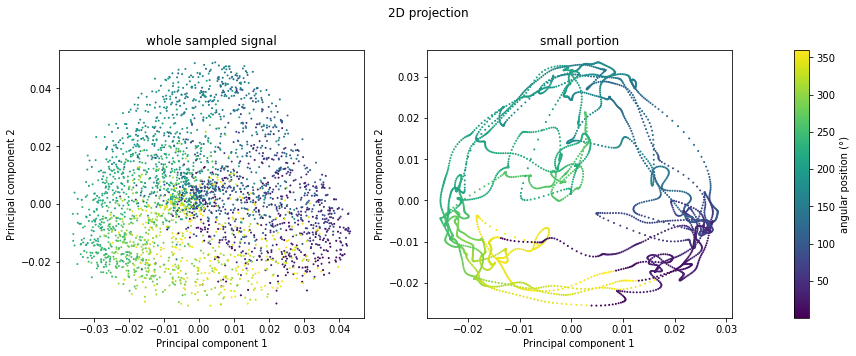

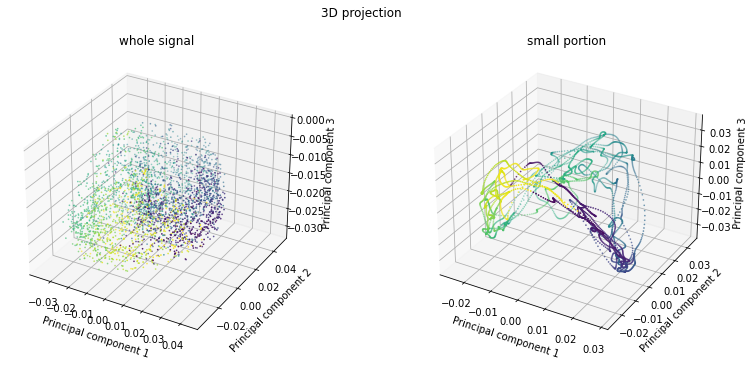

In [16]:
fig,(ax1,ax2,cax)=plt.subplots(1,3,figsize=(12,5),gridspec_kw={"width_ratios":[1,1, 0.05]})
plt.suptitle('2D projection')
ax1.scatter(pc_s[0,:],pc_s[1,:],s=1,c=phi_s)
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')
ax1.title.set_text('whole sampled signal')
im = ax2.scatter(pc_p[0,:],pc_p[1,:],s=1,c=phi[i1:i2])
ax2.set_xlabel('Principal component 1')
ax2.set_ylabel('Principal component 2')
ax2.title.set_text('small portion')
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('angular position (°)')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(12,5))
plt.suptitle('3D projection')
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(pc_s[0,:],pc_s[1,:],pc_s[2,:],s=0.5,c=phi_s)
ax1.set_xlabel('Principal component 1')
ax1.set_ylabel('Principal component 2')
ax1.set_zlabel('Principal component 3')
ax1.title.set_text('whole signal')
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter(pc_p[0,:],pc_p[1,:],pc_p[2,:],s=0.5,c=phi[i1:i2])
ax2.set_xlabel('Principal component 1')
ax2.set_ylabel('Principal component 2')
ax2.set_zlabel('Principal component 3')
ax2.title.set_text('small portion')
plt.tight_layout()
plt.show()

We projected the data to a lower-dimensional space that preserves most of the variance. The study here just showed that the data lie on a manifold of much lower dimension. Thanks to the color code for the corresponding angular position of the mouse, we observe that same phi corresponds to same locations in the manifold. The analysis of these manifolds can therefore indicate that the spatial information (angular position) could be extracted from a low-dimensional subspace of the whole system. In other words, it is possible to decode the angular position of the mouse with only the two firsts princpal composents.

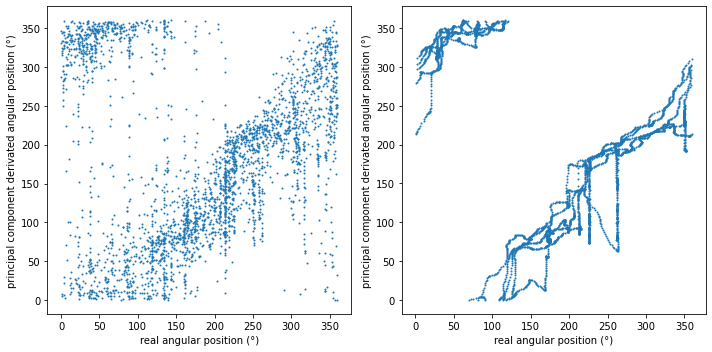

In [17]:
complex_s = pc_s[0,:]+1j*pc_s[1,:]
angle_s = 180*np.angle(complex_s)/np.pi
angle_s[angle_s<0]=360+angle_s[angle_s<0]
complex_p = pc_p[0,:]+1j*pc_p[1,:]
angle_p = 180*np.angle(complex_p)/np.pi
angle_p[angle_p<0]=360+angle_p[angle_p<0]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.scatter(phi_s,angle_s,s=1)
ax1.set_xlabel('real angular position (°)')
ax1.set_ylabel('principal component derivated angular position (°)')
ax2.scatter(phi[i1:i2],angle_p,s=1)
ax2.set_xlabel('real angular position (°)')
ax2.set_ylabel('principal component derivated angular position (°)')
plt.tight_layout()
plt.show()

As shown above, the Principal Component Analysis seems to be a reliable method to derivate the angular position of the mouse given the calcium imaging dataset. This study demonstrate the existence of place cells for angular position.

In [18]:
! jupyter nbconvert --to html CW1-Victoire_deSaleon.ipynb

[NbConvertApp] Converting notebook CW1-Victoire_deSaleon.ipynb to html
[NbConvertApp] Writing 2963269 bytes to CW1-Victoire_deSaleon.html
